In [1]:
import random as rnd
import numpy as np
import scipy.stats as stats
import math
from matplotlib import pyplot as plt
import copy
from scipy.spatial.distance import euclidean 

In [2]:
alpha = 0.6
# Период дискретизации
delta_t = 0.5
# Отклонение с.в. w_n
sigma = 0.5
# Стандартное отклонение
delta = 1.5
# Коёффициент, характеризующий среду распространения сигнала
beta = 3
# Число станций
L = 6
# Мощность сигнала, передаваемого базовой станцией
P0 = 90
# Число частиц
M = 10


In [3]:
A = np.array([
    [1, delta_t, delta_t ** 2 / 2, 0, 0, 0],
    [0, 1, delta_t, 0, 0, 0],
    [0, 0, alpha, 0, 0, 0],
    [0, 0, 0, 1, delta_t, delta_t ** 2 / 2],
    [0, 0, 0, 0, 1, delta_t],
    [0, 0, 0, 0, 0, alpha]])

B = np.array([
    [delta_t ** 2 / 2, 0],
    [delta_t, 0],
    [0, 0],
    [0, delta_t ** 2 / 2],
    [0, delta_t],
    [0, 0]])

C = np.array([
    [delta_t ** 2 / 2, 0],
    [delta_t, 0],
    [1, 0],
    [0, delta_t ** 2 / 2],
    [0, delta_t],
    [0, 1]])

U = np.array([
    np.array([0, 0]).T,
    np.array([3.5, 0]).T, 
    np.array([0, 3.5]).T, 
    np.array([-3.5, 0]).T,
    np.array([0, -3.5]).T])

P = 1 / 20 * np.array([
    [16, 1, 1, 1, 1],
    [1, 16, 1, 1, 1],
    [1, 1, 16, 1, 1],
    [1, 1, 1, 16, 1],
    [1, 1, 1, 1, 16]])
parts = 300

In [4]:
# Считываем координаты станций из файла
stations = []
with open('stations.txt', 'r') as f:
    x = f.readline().split()
    y = f.readline().split()
    stations = np.vstack((x, y)).T
stations = np.array(stations).reshape((6, -1)).astype(float)

In [5]:
# Считываем показания станций
y = []
with open('RSSI-measurements.txt', 'r') as f:
    for l in f.readlines():
        y.extend(l.split())
y = np.array(y).reshape((len(stations), -1)).astype(float).T


In [6]:
# Начальное состояние
x_s = np.random.multivariate_normal(np.zeros((L)), np.diag((500, 5, 5, 200, 5, 5)), M)

# Индекс начального состояния марковской цепи для каждой частицы;
u_s = np.random.randint(0, 4, M)

# Вектор ответа
ans = []

In [7]:
# Цикл по наблюдениям
for i in range(len(y)):
    #print("it {}".format(i))
    w = np.zeros((M))
    # Цикл по частицам
    for j in range(M):
        # Прогноз
        trans = stats.rv_discrete(values=(np.arange(5), P[u_s[j]]))
        u_s[j] = trans.rvs()
        x_s[j] = np.dot(A, x_s[j]) + np.dot(B, U[u_s[j]])
        x_s[j] += np.dot(C, np.random.multivariate_normal(np.zeros((2)), np.diag((sigma ** 2, sigma ** 2))))

        # Коррекция
        y_t = np.zeros(L)
        for k in range(L):
            dist = euclidean(np.array(x_s)[j, [0, 3]], stations[k])
            y_t[k] = P0 - 10 * beta * np.log10(dist)

        w[j] = np.exp(-euclidean(y_t , y[i]) ** 2 / (2 * delta ** 2))

    # Оценка положения объекта
    x_wave = np.zeros(L)
    w /= sum(w)
    for j in range(M):
        x_wave += w[j] * x_s[j]

    #print("coord = {0:.3f} {0:.3f}".format(x_wave[0], x_wave[3]))
    # Сохраняем оценку в траектории и её координаты для построения графика
    ans.append(x_wave)

    # Ресэмплинг
    x_samples = copy.deepcopy(x_s)
    u_samples = copy.deepcopy(u_s)
    w_indices = [i for i in range(len(w))]
    w_dist = stats.rv_discrete(values=(w_indices, w))
    for j in range(M):
        resample_index = w_dist.rvs()
        x_s[j] = x_samples[resample_index]
        u_s[j] = u_samples[resample_index]

      

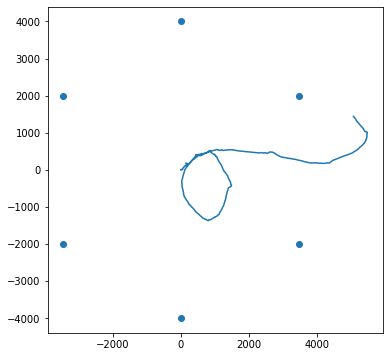

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(stations[:,0], stations[:, 1])
ans = np.array(ans)
plt.plot(ans[:, 0], ans[:, 3])
plt.show()